# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
traj = np.loadtxt(open("simulation/data/traj.txt", "rb"), delimiter=",")
trajPts = np.shape(traj)[0] #points per trajectory
numTraj = np.shape(traj)[1]//3 #number of total trajectories
#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [3]:
#reshape traj data into 3d numpy array
# print(np.shape(traj)) #(10,30) -> should be (10,3,10)
t = np.zeros([trajPts,3,numTraj])
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//3):
        t[j,:,i] = traj[j,3*i:3*(i+1)]
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 3, 10000)
(10000, 3, 10)
(10000, 10, 3)


In [4]:
#Convert data from numpy to tensors

#shuffle data

In [5]:
from network import Net

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

#TODO -> shuffle data


# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [48]:
model = Net() #starting out with basic linear feedforward network (CNN wrote for CIFR-10 does not work with 2D data)

runLen = 500    

def scheduler(epoch, lr):
    part1 = runLen//3
    part2 = 2*runLen//3
    
    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.005
        return lr
    if epoch >= part2:
        lr = 0.001
        return lr


model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Train Model
trace = model.fit(x=x_train, y=y_train, batch_size=256, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 10, 3)             12        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 8, 3)              30        
_________________________________________________________________
batch_normalization_34 (Batc (None, 8, 3)              12        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 6, 3)              30        
_________________________________________________________________
flatten_7 (Flatten)          (None, 18)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

36/36 [==============================] - 0s 3ms/step - loss: 568.5402 - mean_squared_error: 568.5402 - val_loss: 612.8802 - val_mean_squared_error: 612.8802
Epoch 36/500
36/36 [==============================] - 0s 3ms/step - loss: 571.3940 - mean_squared_error: 571.3940 - val_loss: 672.8374 - val_mean_squared_error: 672.8374
Epoch 37/500
36/36 [==============================] - 0s 3ms/step - loss: 562.0143 - mean_squared_error: 562.0143 - val_loss: 658.4226 - val_mean_squared_error: 658.4226
Epoch 38/500
36/36 [==============================] - 0s 3ms/step - loss: 556.5028 - mean_squared_error: 556.5028 - val_loss: 657.4017 - val_mean_squared_error: 657.4017
Epoch 39/500
36/36 [==============================] - 0s 3ms/step - loss: 558.2265 - mean_squared_error: 558.2265 - val_loss: 579.9282 - val_mean_squared_error: 579.9282
Epoch 40/500
36/36 [==============================] - 0s 3ms/step - loss: 562.6246 - mean_squared_error: 562.6246 - val_loss: 621.6667 - val_mean_squared_error: 62

36/36 [==============================] - 0s 3ms/step - loss: 455.8913 - mean_squared_error: 455.8913 - val_loss: 499.5649 - val_mean_squared_error: 499.5649
Epoch 84/500
36/36 [==============================] - 0s 3ms/step - loss: 455.7587 - mean_squared_error: 455.7587 - val_loss: 504.2093 - val_mean_squared_error: 504.2093
Epoch 85/500
36/36 [==============================] - 0s 3ms/step - loss: 447.4909 - mean_squared_error: 447.4909 - val_loss: 498.1046 - val_mean_squared_error: 498.1046
Epoch 86/500
36/36 [==============================] - 0s 3ms/step - loss: 455.2321 - mean_squared_error: 455.2321 - val_loss: 503.0408 - val_mean_squared_error: 503.0408
Epoch 87/500
36/36 [==============================] - 0s 3ms/step - loss: 455.3384 - mean_squared_error: 455.3384 - val_loss: 479.5017 - val_mean_squared_error: 479.5017
Epoch 88/500
36/36 [==============================] - 0s 3ms/step - loss: 451.5790 - mean_squared_error: 451.5790 - val_loss: 529.6411 - val_mean_squared_error: 52

36/36 [==============================] - 0s 3ms/step - loss: 417.1773 - mean_squared_error: 417.1773 - val_loss: 458.9875 - val_mean_squared_error: 458.9875
Epoch 132/500
36/36 [==============================] - 0s 3ms/step - loss: 407.9945 - mean_squared_error: 407.9945 - val_loss: 487.6421 - val_mean_squared_error: 487.6421
Epoch 133/500
36/36 [==============================] - 0s 3ms/step - loss: 414.3351 - mean_squared_error: 414.3351 - val_loss: 504.9859 - val_mean_squared_error: 504.9859
Epoch 134/500
36/36 [==============================] - 0s 3ms/step - loss: 412.3201 - mean_squared_error: 412.3201 - val_loss: 525.3843 - val_mean_squared_error: 525.3843
Epoch 135/500
36/36 [==============================] - 0s 3ms/step - loss: 415.8884 - mean_squared_error: 415.8884 - val_loss: 503.9190 - val_mean_squared_error: 503.9190
Epoch 136/500
36/36 [==============================] - 0s 3ms/step - loss: 406.1412 - mean_squared_error: 406.1412 - val_loss: 509.3277 - val_mean_squared_erro

Epoch 179/500
36/36 [==============================] - 0s 3ms/step - loss: 373.8322 - mean_squared_error: 373.8322 - val_loss: 476.5868 - val_mean_squared_error: 476.5868
Epoch 180/500
36/36 [==============================] - 0s 3ms/step - loss: 372.7948 - mean_squared_error: 372.7948 - val_loss: 450.5910 - val_mean_squared_error: 450.5910
Epoch 181/500
36/36 [==============================] - 0s 3ms/step - loss: 373.3189 - mean_squared_error: 373.3189 - val_loss: 441.6678 - val_mean_squared_error: 441.6678
Epoch 182/500
36/36 [==============================] - 0s 3ms/step - loss: 373.4695 - mean_squared_error: 373.4695 - val_loss: 462.4217 - val_mean_squared_error: 462.4217
Epoch 183/500
36/36 [==============================] - 0s 3ms/step - loss: 371.3102 - mean_squared_error: 371.3102 - val_loss: 434.1082 - val_mean_squared_error: 434.1082
Epoch 184/500
36/36 [==============================] - 0s 4ms/step - loss: 367.9231 - mean_squared_error: 367.9231 - val_loss: 468.3799 - val_mea

Epoch 227/500
36/36 [==============================] - 0s 3ms/step - loss: 360.5392 - mean_squared_error: 360.5392 - val_loss: 437.3452 - val_mean_squared_error: 437.3452
Epoch 228/500
36/36 [==============================] - 0s 3ms/step - loss: 359.4006 - mean_squared_error: 359.4006 - val_loss: 432.5752 - val_mean_squared_error: 432.5752
Epoch 229/500
36/36 [==============================] - 0s 3ms/step - loss: 365.1348 - mean_squared_error: 365.1348 - val_loss: 439.5387 - val_mean_squared_error: 439.5387
Epoch 230/500
36/36 [==============================] - 0s 3ms/step - loss: 357.8609 - mean_squared_error: 357.8609 - val_loss: 468.8476 - val_mean_squared_error: 468.8476
Epoch 231/500
36/36 [==============================] - 0s 3ms/step - loss: 358.0775 - mean_squared_error: 358.0775 - val_loss: 436.3789 - val_mean_squared_error: 436.3789
Epoch 232/500
36/36 [==============================] - 0s 3ms/step - loss: 354.4830 - mean_squared_error: 354.4830 - val_loss: 459.6186 - val_mea

Epoch 275/500
36/36 [==============================] - 0s 3ms/step - loss: 347.9306 - mean_squared_error: 347.9306 - val_loss: 440.8086 - val_mean_squared_error: 440.8086
Epoch 276/500
36/36 [==============================] - 0s 3ms/step - loss: 345.7668 - mean_squared_error: 345.7668 - val_loss: 488.0422 - val_mean_squared_error: 488.0422
Epoch 277/500
36/36 [==============================] - 0s 3ms/step - loss: 350.9278 - mean_squared_error: 350.9278 - val_loss: 481.4101 - val_mean_squared_error: 481.4101
Epoch 278/500
36/36 [==============================] - 0s 3ms/step - loss: 351.4023 - mean_squared_error: 351.4023 - val_loss: 450.8287 - val_mean_squared_error: 450.8287
Epoch 279/500
36/36 [==============================] - 0s 3ms/step - loss: 353.7363 - mean_squared_error: 353.7363 - val_loss: 443.1933 - val_mean_squared_error: 443.1933
Epoch 280/500
36/36 [==============================] - 0s 3ms/step - loss: 349.3419 - mean_squared_error: 349.3419 - val_loss: 438.9460 - val_mea

Epoch 323/500
36/36 [==============================] - 0s 3ms/step - loss: 343.7293 - mean_squared_error: 343.7293 - val_loss: 435.9433 - val_mean_squared_error: 435.9433
Epoch 324/500
36/36 [==============================] - 0s 3ms/step - loss: 346.5718 - mean_squared_error: 346.5718 - val_loss: 434.8770 - val_mean_squared_error: 434.8770
Epoch 325/500
36/36 [==============================] - 0s 3ms/step - loss: 350.0265 - mean_squared_error: 350.0265 - val_loss: 483.5974 - val_mean_squared_error: 483.5974
Epoch 326/500
36/36 [==============================] - 0s 3ms/step - loss: 342.6320 - mean_squared_error: 342.6320 - val_loss: 431.8684 - val_mean_squared_error: 431.8684
Epoch 327/500
36/36 [==============================] - 0s 3ms/step - loss: 344.1785 - mean_squared_error: 344.1785 - val_loss: 444.7453 - val_mean_squared_error: 444.7453
Epoch 328/500
36/36 [==============================] - 0s 3ms/step - loss: 348.2047 - mean_squared_error: 348.2047 - val_loss: 432.7505 - val_mea

Epoch 371/500
36/36 [==============================] - 0s 3ms/step - loss: 321.6108 - mean_squared_error: 321.6108 - val_loss: 417.7505 - val_mean_squared_error: 417.7505
Epoch 372/500
36/36 [==============================] - 0s 3ms/step - loss: 322.4188 - mean_squared_error: 322.4188 - val_loss: 418.0026 - val_mean_squared_error: 418.0026
Epoch 373/500
36/36 [==============================] - 0s 3ms/step - loss: 321.8476 - mean_squared_error: 321.8476 - val_loss: 418.9264 - val_mean_squared_error: 418.9264
Epoch 374/500
36/36 [==============================] - 0s 3ms/step - loss: 320.7692 - mean_squared_error: 320.7692 - val_loss: 431.0573 - val_mean_squared_error: 431.0573
Epoch 375/500
36/36 [==============================] - 0s 3ms/step - loss: 326.4309 - mean_squared_error: 326.4309 - val_loss: 420.6248 - val_mean_squared_error: 420.6248
Epoch 376/500
36/36 [==============================] - 0s 3ms/step - loss: 323.9336 - mean_squared_error: 323.9336 - val_loss: 421.4886 - val_mea

Epoch 419/500
36/36 [==============================] - 0s 3ms/step - loss: 324.4205 - mean_squared_error: 324.4205 - val_loss: 418.8320 - val_mean_squared_error: 418.8320
Epoch 420/500
36/36 [==============================] - 0s 3ms/step - loss: 319.5478 - mean_squared_error: 319.5478 - val_loss: 418.7566 - val_mean_squared_error: 418.7566
Epoch 421/500
36/36 [==============================] - 0s 3ms/step - loss: 322.9485 - mean_squared_error: 322.9485 - val_loss: 425.4579 - val_mean_squared_error: 425.4579
Epoch 422/500
36/36 [==============================] - 0s 3ms/step - loss: 321.6569 - mean_squared_error: 321.6569 - val_loss: 422.0633 - val_mean_squared_error: 422.0633
Epoch 423/500
36/36 [==============================] - 0s 3ms/step - loss: 319.9396 - mean_squared_error: 319.9396 - val_loss: 421.5797 - val_mean_squared_error: 421.5797
Epoch 424/500
36/36 [==============================] - 0s 3ms/step - loss: 315.5464 - mean_squared_error: 315.5464 - val_loss: 430.6672 - val_mea

Epoch 467/500
36/36 [==============================] - 0s 3ms/step - loss: 317.0405 - mean_squared_error: 317.0405 - val_loss: 417.1083 - val_mean_squared_error: 417.1083
Epoch 468/500
36/36 [==============================] - 0s 3ms/step - loss: 321.1015 - mean_squared_error: 321.1015 - val_loss: 421.7224 - val_mean_squared_error: 421.7224
Epoch 469/500
36/36 [==============================] - 0s 3ms/step - loss: 321.7171 - mean_squared_error: 321.7171 - val_loss: 423.0179 - val_mean_squared_error: 423.0179
Epoch 470/500
36/36 [==============================] - 0s 3ms/step - loss: 320.1820 - mean_squared_error: 320.1820 - val_loss: 418.8100 - val_mean_squared_error: 418.8100
Epoch 471/500
36/36 [==============================] - 0s 3ms/step - loss: 317.1371 - mean_squared_error: 317.1371 - val_loss: 419.4934 - val_mean_squared_error: 419.4934
Epoch 472/500
36/36 [==============================] - 0s 3ms/step - loss: 317.4007 - mean_squared_error: 317.4007 - val_loss: 422.2585 - val_mea

(200.0, 1000.0)

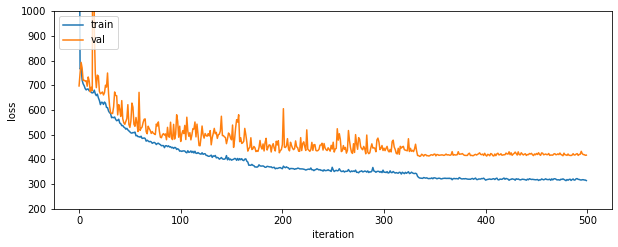

In [49]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(200,1000)

In [79]:
#test model
prediction = model.predict(x_train[-100:-1])
# print(prediction)
actual = y_train[-100:-1]
# print(actual)

error = (actual - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [20, 20, 10, 110, 120, 120, 130]
rel_error = avg/ranges
print("error as frac of joint range = ", rel_error) #1 is full range of joint
print(sum(rel_error))
#current best is: [0.24196801 0.2422539  0.25829763 0.19483868 0.17223358 0.17577043 0.13885703]

average error =  [ 4.83936    4.845078   2.5829763 21.432255  20.66803   21.092451
 18.051414 ]
error as frac of joint range =  [0.24196801 0.2422539  0.25829763 0.19483868 0.17223358 0.17577043
 0.13885703]
1.4242192673516438


In [77]:
#verify my model is doing better than completely random guessing
# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([100,99,7])
# print(tf.shape(B))
B = B *tf.constant([10., 10., 5., 110.,120.,120.,130.]) + tf.constant([0., 0., 0., -90., -30., -30., 0.])
# print(tf.shape(B))

fake_error = (actual - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
# print(fake_avg)

# print(fake_avg/ranges)

tf.Tensor(
[[[-4.79631233e+00 -1.85298443e-01 -1.14042592e+00 ...  2.43642044e+01
    7.39303589e+01 -1.27287529e+02]
  [-6.40725708e+00 -1.70276618e+00 -4.12397718e+00 ...  2.54562187e+00
   -5.56370201e+01 -1.07209305e+02]
  [-1.06385851e+01 -1.20110989e+01 -2.79524803e+00 ...  4.80841141e+01
   -1.72215118e+01 -1.25471405e+02]
  ...
  [-9.13757992e+00  2.25481749e-01 -1.53487897e+00 ...  9.54246521e-01
   -5.32172165e+01 -1.01985748e+02]
  [-1.10521688e+01 -3.49984169e+00 -5.57809973e+00 ...  4.40194969e+01
   -7.57216949e+01 -1.60236710e+02]
  [-6.59514332e+00 -6.13219070e+00 -1.51888859e+00 ... -8.28410645e+01
    1.16388168e+01 -7.18786316e+01]]

 [[-4.23204136e+00  4.92531204e+00 -3.26630235e+00 ...  2.58241272e+01
    3.47874641e+01 -2.07501358e+02]
  [-1.17116566e+01  3.40089583e+00 -5.17106771e+00 ...  9.27935600e+00
   -2.70626411e+01 -1.54979004e+02]
  [-1.61235409e+01 -6.47629547e+00 -7.13113010e-01 ...  6.34259796e+01
   -2.42922592e+01 -1.70514832e+02]
  ...
  [-3.555898

In [58]:
tf.random.uniform([3,3,2])

<tf.Tensor: shape=(3, 3, 2), dtype=float32, numpy=
array([[[0.01199913, 0.17785299],
        [0.07796204, 0.81927025],
        [0.42075324, 0.21537542]],

       [[0.83344805, 0.19597614],
        [0.75399506, 0.49244547],
        [0.3440982 , 0.5401174 ]],

       [[0.27604616, 0.86997795],
        [0.9984684 , 0.81474686],
        [0.60792804, 0.78341496]]], dtype=float32)>